In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.utils as np_utils
import random
from IPython.display import HTML, display

In [12]:
num_patterns = 200
num_features = 2
num_classes = 2
mu, sigma = 0, 0.5

Xred = np.random.normal(mu, sigma, (num_patterns, num_features)) + np.array([0.5, 0.5])
Yred = np.zeros(num_patterns, dtype=int)
Xblue = np.random.normal(mu, sigma,(num_patterns, num_features)) + np.array([-0.5, -0.5])
Yblue = np.ones(num_patterns, dtype=int) * 1
X = np.concatenate((Xred, Xblue), axis=0)
num_patterns = num_patterns * num_classes
Y = np.concatenate((Yred, Yblue), axis=0)

#standarize
Y_hot = np.zeros((Y.size, Y.max()+1))
Y_hot[np.arange(Y.size),Y] = 1
Y = np.reshape(Y, (-1,1))


(400, 2)


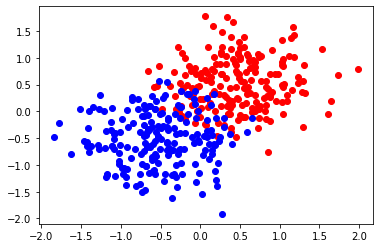

In [13]:
print(X.shape)
plt.scatter(X[0:int(num_patterns/2),0], X[0:int(num_patterns/2),1], color='red')
plt.scatter(X[int(num_patterns/2): int(2*num_patterns/2),0], X[int(num_patterns/2): int(2*num_patterns/2),1], color='blue')

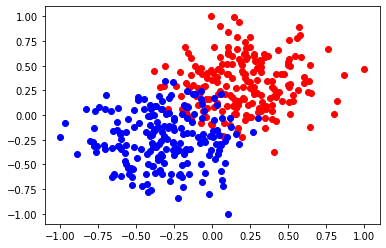

In [14]:
X = 2*((X - X.min(0)) / X.ptp(0)) -1
plt.scatter(X[0:int(num_patterns/2),0], X[0:int(num_patterns/2),1], color='red')
plt.scatter(X[int(num_patterns/2): int(2*num_patterns/2),0], X[int(num_patterns/2): int(2*num_patterns/2),1], color='blue')

In [15]:
percent = 0.8
n = int(percent * num_patterns) 
indexes = [i for i in range(num_patterns)]
random.shuffle(indexes)

index_train = indexes[0:n]
index_test = indexes[n::]

y_train = Y[index_train, :]
y_test = Y[index_test, :]
X_train = X[index_train, :]
X_test = X[index_test, :]

batch_size = 10
epochs = 50

def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=num_features, activation='softmax'))

    return model

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

model = build_logistic_model(num_features, num_classes)

model.summary()

# compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.4960 - accuracy: 0.9031 - val_loss: 0.4571 - val_accuracy: 0.9625
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4866 - accuracy: 0.9094 - val_loss: 0.4476 - val_accuracy: 0.9750
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4778 - accuracy: 0.9062 - val_loss: 0.4385 - val_accuracy: 0.9750
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4695 - accuracy: 0.9031 - val_loss: 0.4298 - val_accuracy: 0.9750
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4617 - accuracy: 0.

In [16]:
model.predict(X_test)
pred = model.predict(np.array(X_test))
predictions = np.argmax(pred, axis=-1)

inference = np.concatenate((np.reshape(pred, (-1,num_classes)), np.reshape(predictions, (-1,1)), y_test), axis=1)
inference_sorted = np.array(sorted(inference, key=lambda a_entry: 1.0/a_entry[1]))
num_test_patterns = inference_sorted.shape[0]
display(HTML(
   '<table border="1" ><tr><td>Negative Class Output</td><td>Positive Class Output</td><td>Predicted</td><td>Target</td></tr><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in inference_sorted)
       )
))


Negative Class Output,Positive Class Output,Predicted,Target
0.042072247713804245,0.9579277634620667,1.0,1.0
0.042982179671525955,0.9570178389549255,1.0,1.0
0.04346957430243492,0.9565303921699524,1.0,1.0
0.05416117608547211,0.9458388686180115,1.0,1.0
0.0637805163860321,0.9362194538116455,1.0,1.0
0.06660433858633041,0.9333956837654114,1.0,1.0
0.06697041541337967,0.9330295920372009,1.0,1.0
0.06697450578212738,0.9330254793167114,1.0,1.0
0.0738486498594284,0.9261512756347656,1.0,1.0
0.08756120502948761,0.9124387502670288,1.0,1.0


P_target         is the real amount of positives  
N_target         is the real amount of negatives  
P_predicted      is the amount of positives predicted  
N_predicted      is the amount of negatives predicted

In [17]:
P_target = np.sum(y_test)
N_target = num_test_patterns - P_target

# At the beggining of ROC contruction all patterns are predicted as false because the thresold is maximun

TP = 0              #labeled 1  predicted 1
FN = P_target       #labeled 1  predicted 0
FP = 0              #labeled 0  predicted 1 
TN = N_target       #labeled 1 predicted 0

x = []
y = []

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
x.append(FPR)
y.append(TPR)

target = inference_sorted[:, 3]
predicted = inference_sorted[:, 2]
for i in range(num_test_patterns):

    if(target[i] == 1):
        TP += 1
        FN -= 1
    else:
        TN -= 1
        FP += 1
    
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    x.append(FPR)
    y.append(TPR)



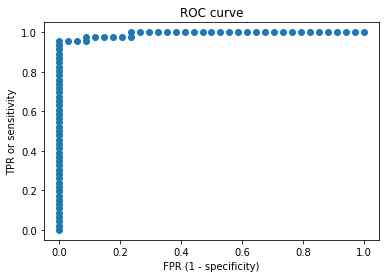

In [18]:
fig, ax = plt.subplots()
plt.title('ROC curve')
ax.set_ylabel('TPR or sensitivity') 
ax.set_xlabel('FPR (1 - specificity)') 
plt.scatter(x, y)

In [19]:
AUC = 0
for i in range(2, num_test_patterns):
    AUC += (x[i] - x[i-1])*(y[i] + y[i-1])/2

print(AUC)

0.9635549872122762
